In [1]:
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 100)

# To remove pandas copy warnings (may need to turn on if writing new functions):
#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
from Bio.PDB import *
import community
import networkx as nx
import igraph as ig
from sklearn.metrics.cluster import normalized_mutual_info_score
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
%matplotlib inline
from IPython.display import Image

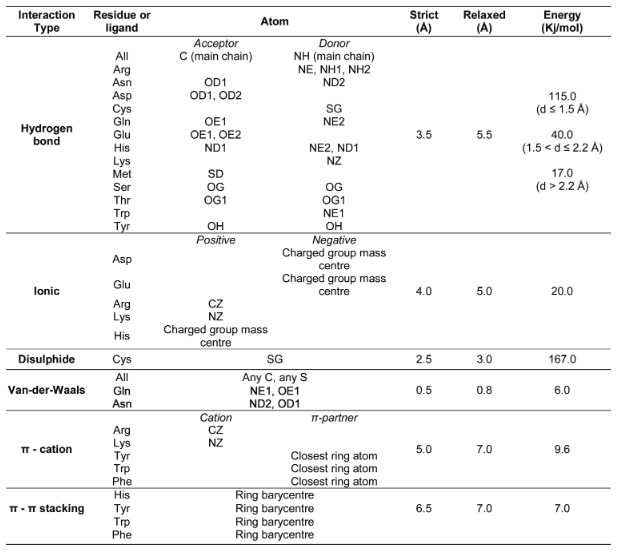

In [2]:
Image('./figs/RING_energy_dist.png')

In [3]:
EsCo_edges = pd.read_csv('../../Ring_Analysis/4v9d_phase_as_chains/4v9d_phase_as_chains_edges.txt', sep='\t')
EsCo_edges

NodeId1  Interaction      NodeId2  Distance    Angle  Energy Atom1  \
0       0:3:_:GLN    VDW:SC_SC    0:7:_:PRO     3.427 -999.900     6.0   NE2   
1       0:8:_:THR  HBOND:SC_MC   0:11:_:LYS     2.954   17.792    17.0   OG1   
2       0:8:_:THR  HBOND:MC_MC   0:12:_:ARG     3.046    7.256    17.0     O   
3       0:9:_:ARG    VDW:SC_SC   0:12:_:ARG     3.839 -999.900     6.0    CB   
4       0:9:_:ARG  HBOND:MC_MC   0:13:_:GLY     3.303    9.562    17.0     O   
...           ...          ...          ...       ...      ...     ...   ...   
49700  z:2496:_:C  IAC:LIG_LIG  z:3071:_:MG     4.549 -999.900     0.0    N4   
49701  z:2497:_:A  IAC:LIG_LIG   z:2500:_:U     6.587 -999.900     0.0    N3   
49702  z:2497:_:A  IAC:LIG_LIG  z:3071:_:MG     4.471 -999.900     0.0    N1   
49703  z:2498:_:C  IAC:LIG_LIG  z:3071:_:MG     6.112 -999.900     0.0    N4   
49704  z:2499:_:C  IAC:LIG_LIG  z:3071:_:MG     6.183 -999.900     0.0    N4   

      Atom2       Donor Positive Cation Orientation  
0        CD         NaN      NaN    NaN         NaN  
1         N  0:11:_:LYS      NaN    NaN         NaN  
2         N  0:12:_:ARG      NaN    NaN         NaN  
3        CZ         NaN      NaN    NaN         NaN  
4         N  0:13:_:GLY      NaN    NaN         NaN  
...     ...         ...      ...    ...         ...  
49700    MG         NaN      NaN    NaN         NaN  
49701    O4         NaN      NaN    NaN         NaN  
49702    MG         NaN      NaN    NaN         NaN  
49703    MG         NaN      NaN    NaN         NaN  
49704    MG         NaN      NaN    NaN         NaN  

[49705 rows x 12 columns]

In [5]:
EsCo_nodes = pd.read_csv('../../Ring_Analysis/4v9d_phase_as_chains/4v9d_phase_as_chains_nodes_xyz.txt')
name_chains = pd.read_csv('../../Ring_Analysis/4v9d_phase_as_chains/4v9d_name_chains.csv', names=['Object', 'Chain'])
EsCo_nodes = pd.merge(EsCo_nodes, name_chains, on='Chain')
EsCo_nodes

NodeId Chain  Position Residue Dssp  Degree  Bfactor_CA    Rapdf  \
0      z:1402:Z:C     z      1402       C  NaN      16     -999.90 -999.900   
1      z:1403:Z:C     z      1403       C  NaN      12     -999.90 -999.900   
2      z:1404:Z:C     z      1404       C  NaN      10     -999.90 -999.900   
3      z:1405:Z:G     z      1405       G  NaN      12     -999.90 -999.900   
4      z:1406:Z:U     z      1406       U  NaN      13     -999.90 -999.900   
...           ...   ...       ...     ...  ...     ...         ...      ...   
10511  4:35:_:GLN     4        35     GLN    E       7        0.01   37.257   
10512  4:36:_:ARG     4        36     ARG    E      16        0.01   44.565   
10513  4:37:_:GLN     4        37     GLN           13       12.82   42.725   
10514  4:38:_:GLY     4        38     GLY            7        0.01   10.721   
10515  4:101:_:ZN     4       101      ZN  NaN      18     -999.90 -999.900   

           Tap  Accessibility           x          y          z  Object  
0     -999.900       -999.900  -98.388000  25.709000 -15.153000  Phase1  
1     -999.900       -999.900  -92.976997  22.837000 -14.876000  Phase1  
2     -999.900       -999.900  -88.810997  18.989000 -12.866000  Phase1  
3     -999.900       -999.900  -86.110001  13.792000 -11.342000  Phase1  
4     -999.900       -999.900  -85.891998   7.446000 -10.625000  Phase1  
...        ...            ...         ...        ...        ...     ...  
10511   -0.009          0.013 -108.461998 -66.489998 -43.130001    bL36  
10512   -1.319          0.387 -106.526001 -68.943001 -40.921001    bL36  
10513    0.770          0.458 -106.081001 -70.386002 -37.396000    bL36  
10514    0.000          0.596 -109.782997 -70.748001 -36.787998    bL36  
10515 -999.900       -999.900 -115.719002 -63.391998 -48.875999    bL36  

[10516 rows x 14 columns]

In [6]:
def plot_nodes(df):    
    
    data = []
    
    for rPro in set(df['Object']):
        
        rPro_df = df[df['Object'] == rPro]
        data.append(
        go.Scatter3d(
            x = rPro_df['x'],
            y = rPro_df['y'],
            z = rPro_df['z'],
            text = 
                rPro_df['Residue']
                +' '+rPro_df['Dssp'],
            mode = 'markers',
            name = rPro
            )
        )

    layout = go.Layout(
        title = 'Thermus thermophilus Nodes (Atoms) Colored by rProtein and rRNA Phase',
        showlegend = True
    )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [8]:
plot_nodes(EsCo_nodes)

In [10]:
plot_nodes(EsCo_nodes[EsCo_nodes.Object == 'uL04'])

Unofortunately, I only modified the txt files that I use to make the plots, the xml file still does not have an updated x, y, z. However, I still try and use the dataframe as often as possible

In [11]:
G_EsCo = nx.read_graphml('../../Ring_Analysis/4v9d_phase_as_chains/4v9d_phase_as_chains_network.xml')

In [12]:
G_EsCo.nodes['n0']

{'Accessibility': -999.9,
 'Bfactor_CA': -999.9,
 'Degree': 16.0,
 'NodeId': 'z:1402:Z:C',
 'Position': 1402.0,
 'Rapdf': -999.9,
 'Residue': 'C',
 'Tap': -999.9,
 'name': 'z:1402:Z:C',
 'pdbFileName': '4v9d_phase_as_chains.pdb#1402.z',
 'x': -999.9,
 'y': -999.9,
 'z': -999.9}

In [14]:
G_EsCo.edges[('n0', 'n247', 0)]

{'Angle': -999.9,
 'Atom1': "O2'",
 'Atom2': "O3'",
 'Cation': 'None',
 'Distance': 4.119,
 'Donor': 'None',
 'Energy': 0.0,
 'Interaction': 'IAC:LIG_LIG',
 'NodeId1': 'z:1402:Z:C',
 'NodeId2': '5:1394:Z:A',
 'Orientation': 'None',
 'Positive': 'None'}

In [15]:
def print_top_bottom_5(metric):
    top5 = {key: metric[key] for key in sorted(metric, key=metric.get, reverse=True)[:5]}
    bottom5 = {key: metric[key] for key in sorted(metric, key=metric.get, reverse=False)[:5]}
    print('top5:')
    for x in top5:
        print(x, '\t', top5[x])
    print('bottom5:')
    for x in bottom5:
        print(x, '\t', bottom5[x])

In [16]:
def print_centrality(graph):
    degree = nx.degree_centrality(graph)
    #closeness = nx.closeness_centrality(graph) #takes a long time
    #harmonic = nx.harmonic_centrality(graph) #takes a long time
    #betweenness = nx.betweenness_centrality(graph) #takes a long time
    eigenvector = nx.eigenvector_centrality_numpy(graph)
    # pagerank_085 = nx.pagerank_numpy(graph, alpha=0.85) #takes a long time
    # Katz does not work on multigraph
    print('degree:')
    print_top_bottom_5(degree)
    #print('\ncloseness:')
    #print_top_bottom_5(closeness)
    #print('\nharmonic:')
    #print_top_bottom_5(harmonic)
    #print('\nbetweenness:')
    #print_top_bottom_5(betweenness)
    print('\neigenvector:')
    print_top_bottom_5(eigenvector)
    #print('\npagerank alpha=0.85:')
    #print_top_bottom_5(pagerank_085)

### Takes a while to run

In [17]:
print_centrality(G_EsCo)

degree:
top5:
n2695 	 0.003409090909090909
n912 	 0.0032196969696969696
n2008 	 0.0032196969696969696
n1520 	 0.003125
n2911 	 0.003125
bottom5:
n2043 	 9.46969696969697e-05
n2295 	 9.46969696969697e-05
n2296 	 9.46969696969697e-05
n2297 	 9.46969696969697e-05
n2620 	 9.46969696969697e-05

eigenvector:
top5:
n834 	 0.136709083323
n835 	 0.133684645518
n917 	 0.132149905498
n916 	 0.12566210651
n699 	 0.124613668603
bottom5:
n4931 	 -3.69826125647e-18
n7126 	 -3.20240205909e-18
n9644 	 -3.01874538222e-18
n9643 	 -2.81537943498e-18
n8357 	 -2.54008176528e-18


In [18]:
def plot_nodes_partitions(df):  
    
    data = []
    
    for partition_count in range(df['partition'].max()):
        
        partition_df = df[df['partition'] == partition_count]
        data.append(
        go.Scatter3d(
            x = partition_df['x'],
            y = partition_df['y'],
            z = partition_df['z'],
            text = 
                partition_df['Residue']
                +' '+partition_df['Dssp']
                +' '+partition_df['Chain']
                +' '+partition_df['Object'],
            mode = 'markers',
            name = 'partition'+str(partition_count)
            )
        )
        
    layout = go.Layout(
        title = 'Coloring ThTh rProteins and rRNA Phases by Community',
        showlegend = True
    )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [21]:
def plot_louvain(res, G, make_plot=True):
    partition = community.best_partition(G, resolution=res, weight='Energy')
    partition_df = pd.DataFrame.from_dict(partition, orient='index').reset_index()
    partition_df.rename(columns={0:'partition'}, inplace=True)
    EsCo_partition = EsCo_nodes.join(partition_df)
    EsCo_partition = EsCo_partition.drop(['index'], axis=1)
    print('Resolution:', res)
    print('Number of partitions:',len(set(partition.values())))
    print('Modularity:', community.modularity(partition, G))
    if make_plot == True:
        plot_nodes_partitions(EsCo_partition)
#        EsCo_partition = EsCo_partition[~EsCo_partition.partition.isnull()]
#        EsCo_partition.partition = EsCo_partition.partition.astype(int)
#        plot_nodes_partitions(EsCo_partition)
    return(partition, EsCo_partition)

In [22]:
louvain5, lv5_df = plot_louvain(5, G_EsCo, make_plot=True)

Resolution: 5
Number of partitions: 74
Modularity: 0.7958522770514428


In [23]:
lv5_df

NodeId Chain  Position Residue Dssp  Degree  Bfactor_CA    Rapdf  \
0      z:1402:Z:C     z      1402       C  NaN      16     -999.90 -999.900   
1      z:1403:Z:C     z      1403       C  NaN      12     -999.90 -999.900   
2      z:1404:Z:C     z      1404       C  NaN      10     -999.90 -999.900   
3      z:1405:Z:G     z      1405       G  NaN      12     -999.90 -999.900   
4      z:1406:Z:U     z      1406       U  NaN      13     -999.90 -999.900   
...           ...   ...       ...     ...  ...     ...         ...      ...   
10511  4:35:_:GLN     4        35     GLN    E       7        0.01   37.257   
10512  4:36:_:ARG     4        36     ARG    E      16        0.01   44.565   
10513  4:37:_:GLN     4        37     GLN           13       12.82   42.725   
10514  4:38:_:GLY     4        38     GLY            7        0.01   10.721   
10515  4:101:_:ZN     4       101      ZN  NaN      18     -999.90 -999.900   

           Tap  Accessibility           x          y          z  Object  \
0     -999.900       -999.900  -98.388000  25.709000 -15.153000  Phase1   
1     -999.900       -999.900  -92.976997  22.837000 -14.876000  Phase1   
2     -999.900       -999.900  -88.810997  18.989000 -12.866000  Phase1   
3     -999.900       -999.900  -86.110001  13.792000 -11.342000  Phase1   
4     -999.900       -999.900  -85.891998   7.446000 -10.625000  Phase1   
...        ...            ...         ...        ...        ...     ...   
10511   -0.009          0.013 -108.461998 -66.489998 -43.130001    bL36   
10512   -1.319          0.387 -106.526001 -68.943001 -40.921001    bL36   
10513    0.770          0.458 -106.081001 -70.386002 -37.396000    bL36   
10514    0.000          0.596 -109.782997 -70.748001 -36.787998    bL36   
10515 -999.900       -999.900 -115.719002 -63.391998 -48.875999    bL36   

       partition  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
10511          4  
10512          4  
10513          4  
10514          4  
10515          4  

[10516 rows x 15 columns]

In [24]:
G_EsCo['n5555']

AdjacencyView({'n5528': {0: {'Distance': 3.319, 'Interaction': 'VDW:SC_SC', 'Angle': -999.9, 'Orientation': 'None', 'Positive': 'None', 'Energy': 6.0, 'Atom1': 'CG1', 'Atom2': 'CB', 'Cation': 'None', 'NodeId2': 'e:66:_:ALA', 'NodeId1': 'e:38:_:VAL', 'Donor': 'None'}}, 'n5535': {0: {'Distance': 4.013, 'Interaction': 'VDW:MC_SC', 'Angle': -999.9, 'Orientation': 'None', 'Positive': 'None', 'Energy': 6.0, 'Atom1': 'C', 'Atom2': 'CB', 'Cation': 'None', 'NodeId2': 'e:66:_:ALA', 'NodeId1': 'e:46:_:GLY', 'Donor': 'None'}}, 'n5551': {0: {'Distance': 3.332, 'Interaction': 'HBOND:MC_MC', 'Angle': 35.637, 'Orientation': 'None', 'Positive': 'None', 'Energy': 17.0, 'Atom1': 'O', 'Atom2': 'N', 'Cation': 'None', 'NodeId2': 'e:66:_:ALA', 'NodeId1': 'e:62:_:ALA', 'Donor': 'e:66:_:ALA'}}, 'n5552': {0: {'Distance': 2.699, 'Interaction': 'HBOND:MC_MC', 'Angle': 34.873, 'Orientation': 'None', 'Positive': 'None', 'Energy': 17.0, 'Atom1': 'O', 'Atom2': 'N', 'Cation': 'None', 'NodeId2': 'e:66:_:ALA', 'NodeId1'

In [25]:
nx.get_node_attributes(G_ThTh, 'n0')

{}

In [26]:
louvain5

{'n0': 0,
 'n1': 0,
 'n2': 0,
 'n3': 0,
 'n4': 1,
 'n5': 0,
 'n6': 0,
 'n7': 1,
 'n8': 0,
 'n9': 0,
 'n10': 0,
 'n11': 0,
 'n12': 0,
 'n13': 0,
 'n14': 2,
 'n15': 2,
 'n16': 2,
 'n17': 2,
 'n18': 2,
 'n19': 2,
 'n20': 2,
 'n21': 2,
 'n22': 0,
 'n23': 2,
 'n24': 2,
 'n25': 0,
 'n26': 0,
 'n27': 0,
 'n28': 0,
 'n29': 0,
 'n30': 0,
 'n31': 2,
 'n32': 0,
 'n33': 0,
 'n34': 0,
 'n35': 0,
 'n36': 3,
 'n37': 0,
 'n38': 0,
 'n39': 0,
 'n40': 3,
 'n41': 0,
 'n42': 0,
 'n43': 0,
 'n44': 0,
 'n45': 0,
 'n46': 0,
 'n47': 0,
 'n48': 0,
 'n49': 0,
 'n50': 0,
 'n51': 0,
 'n52': 0,
 'n53': 0,
 'n54': 0,
 'n55': 0,
 'n56': 0,
 'n57': 0,
 'n58': 0,
 'n59': 0,
 'n60': 0,
 'n61': 0,
 'n62': 0,
 'n63': 0,
 'n64': 0,
 'n65': 0,
 'n66': 0,
 'n67': 0,
 'n68': 0,
 'n69': 0,
 'n70': 0,
 'n71': 0,
 'n72': 0,
 'n73': 0,
 'n74': 0,
 'n75': 0,
 'n76': 0,
 'n77': 0,
 'n78': 0,
 'n79': 0,
 'n80': 0,
 'n81': 0,
 'n82': 0,
 'n83': 0,
 'n84': 0,
 'n85': 0,
 'n86': 0,
 'n87': 0,
 'n88': 0,
 'n89': 0,
 'n90': 0,
 'n91': 0

In [27]:
nx.set_node_attributes(G_ThTh, 'lv5_community', louvain5)

TypeError: unhashable type: 'dict'

In [28]:
louvain6, lv6_df = plot_louvain(6, G_ThTh, False)

Resolution: 6
Number of partitions: 194
Modularity: 0.7759185585362102


In [29]:
normalized_mutual_info_score(list(louvain5.values()), list(louvain6.values()))

0.98884494472938012

In [30]:
resolution = np.linspace(1, 20, num=39, endpoint=True, retstep=False, dtype=None)
resolution

array([  1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,   4.5,   5. ,
         5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,   9. ,   9.5,
        10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,  13.5,  14. ,
        14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,  18. ,  18.5,
        19. ,  19.5,  20. ])

In [31]:
def make_prtn_mod_res_df(resolution_list, G):
    modularity_list = []
    partition_list = []
    
    for res in resolution:
        partition = community.best_partition(G, resolution=res, weight='Energy')
        num_partitions = len(set(partition.values()))
        modularity = community.modularity(partition, G)
        modularity_list.append(modularity)
        partition_list.append(num_partitions)
    
    df = pd.DataFrame(
        {'Resolution':resolution_list,
         'Num_Partitions':partition_list,
         'Modularity':modularity_list})
    
    return(df)

### This next cell takes a crazy long time to run, graph below may be an old version

In [32]:
prtn_mod_res_df = make_prtn_mod_res_df(resolution, G_ThTh)

# Create traces
trace0 = go.Scatter(
    x = prtn_mod_res_df['Resolution'],
    y = prtn_mod_res_df['Num_Partitions'],
    mode = 'lines',
    name = 'Partitions'
)
trace1 = go.Scatter(
    x = prtn_mod_res_df['Resolution'],
    y = prtn_mod_res_df['Modularity'],
    mode = 'lines',
    name = 'Modularity',
    yaxis='y2'
)


layout = go.Layout(
    title='Modularity and Parition Number vs. Louvain Resoution',
    xaxis=dict(
        title='Louvain Resolution'
    ),
    yaxis=dict(
        title='Number of Partitions'
    ),
    yaxis2=dict(
        title='Modularity',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
    )
)

data = [trace0, trace1]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [35]:
def plot_nodes_partitions(df):  
    
    data = []
    
    for partition_count in range(df['partition'].max()):
        
        partition_df = df[df['partition'] == partition_count]
        partition_df.Position = partition_df.Position.astype(str)
        data.append(
            go.Scatter3d(
                x = partition_df['x'],
                y = partition_df['y'],
                z = partition_df['z'],
                text = 
                    partition_df['Residue']
                    +' '+partition_df['Position']
                    +' '+partition_df['Dssp']
                    +' '+partition_df['Chain']
                    +' '+partition_df['Object'],
                mode = 'markers',
                name = 'partition'+str(partition_count)
            )
        )
        
    layout = go.Layout(
        title = 'Coloring ThTh rProteins and rRNA Phases by Community',
        showlegend = True
    )

    data.append(
    go.Scatter3d(
        x = df['x'],
        y = df['y'],
        z = df['z'],
        mode = 'lines',
        hoverinfo='none'
        )
    )
    
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [40]:
plot_nodes_partitions(lv5_df[lv5_df.Object == 'Phase3'])

/home/nick/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



### Output makes no sense, all nodes are communities

In [23]:
ig_G = ig.Graph.Read_GraphML('../Ring_output/1VY4/1VY4_LSU_rRNA+rProtein_network.xml')

In [24]:
def walktrap_output(stps):
    walktrap = ig.Graph.community_walktrap(ig_G, weights='Energy', steps=stps)
    print('Steps:', stps)
    print('Optimal count:', walktrap.optimal_count)
    print('Modularity:', ig_G.modularity(membership=walktrap.as_clustering()))
    return([e for l in walktrap.merges for e in l])

In [25]:
walktrap2 = walktrap_output(2)

Steps: 2
Optimal count: 5711
Modularity: 0.07320135301685493


In [26]:
walktrap4 = walktrap_output(4)

Steps: 4
Optimal count: 5711
Modularity: 0.07320135301685493


In [27]:
walktrap6 = walktrap_output(6)

Steps: 6
Optimal count: 5711
Modularity: 0.07320135301685493


In [28]:
walktrap8 = walktrap_output(8)

Steps: 8
Optimal count: 5711
Modularity: 0.07320135301685493


In [29]:
walktrap10 = walktrap_output(10)

Steps: 10
Optimal count: 5711
Modularity: 0.07320135301685493


In [30]:
normalized_mutual_info_score(walktrap2, walktrap4)

1.0

In [31]:
walktrap10 = walktrap_output(100)

Steps: 100
Optimal count: 5711
Modularity: 0.07320135301685493


In [32]:
walktrap = ig.Graph.community_walktrap(ig_G, weights='Energy', steps=4)

In [33]:
walktrap

In [34]:
print(walktrap)

Dendrogram, 7374 elements, 7359 merges


In [36]:
ig.

'Dendrogram, 7374 elements, 7359 merges'

In [37]:
def plot_girvan_newman(res, G, make_plot=True):
    partition = girvan_newman(G)
    partition_df = pd.DataFrame.from_dict(partition, orient='index').reset_index()
    partition_df.rename(columns={0:'partition'}, inplace=True)
    ThTh_partition = ThTh_nodes.join(partition_df)
    ThTh_partition = ThTh_partition.drop(['index'], axis=1)
    print('Resolution:', res)
    print('Number of partitions:',len(set(partition.values())))
    print('Modularity:', community.modularity(partition, G))
    if make_plot == True:
        plot_nodes_partitions(ThTh_partition)
#        ThTh_partition = ThTh_partition[~ThTh_partition.partition.isnull()]
#        ThTh_partition.partition = ThTh_partition.partition.astype(int)
#        plot_nodes_partitions(ThTh_partition)
    return(partition, ThTh_partition)

In [39]:
partition = nx.girvan_newman(G_ThTh)

AttributeError: module 'networkx' has no attribute 'girvan_newman'